In [172]:
%run Jansen_And_Rit.py
%run OptimiseFunctions.py
import os
import numpy as np
import mne
from scipy.stats import zscore
import pandas as pd
eeg_raw_data_dir = (
    "C:/Users/stapl/Documents/CDocuments/FinalYearProject/Model/eeg_raw_data"
)

In [257]:
import random
subjects = []
for filename in os.listdir(eeg_raw_data_dir):
    subject_id = int(filename.split("_", 5)[4])
    subjects.append(subject_id)

# Shuffle the list
random.shuffle(subjects)

pairs = []
while len(pairs) < 35:
    for i in range(0, len(subjects) - 1, 2):
        if subjects[i] != subjects[i + 1]:  # Ensure no item is paired with itself
            pairs.append((subjects[i], subjects[i + 1]))

In [258]:
from scipy.stats import pearsonr
losses = []

for (p1, p2) in pairs:

    for filename in os.listdir(eeg_raw_data_dir):

        subject_id = int(filename.split("_", 5)[4])
        if subject_id == p1:

            eeg_path = os.path.join(eeg_raw_data_dir, filename)
            raw1 = mne.io.read_raw_fif(eeg_path, preload=True)
            

    for filename in os.listdir(eeg_raw_data_dir):

        subject_id = int(filename.split("_", 5)[4])
        if subject_id == p2:

            eeg_path = os.path.join(eeg_raw_data_dir, filename)
            raw2 = mne.io.read_raw_fif(eeg_path, preload=True)
            
    ch_names1 = raw1.ch_names
    ch_names2 = raw2.ch_names
    set1 = set(ch_names1)
    set2 = set(ch_names2)
    unique_items = list(set1.symmetric_difference(set2))
    print(len(unique_items))

    raw1 = raw1.drop_channels(unique_items, on_missing='ignore')
    raw2 = raw2.drop_channels(unique_items, on_missing='ignore')

    psd1 = raw1.compute_psd(fmin=0, fmax=80, picks="all")
    psd2 = raw2.compute_psd(fmin=0, fmax=80, picks="all")

    correlation_coefficients = []

    psd1 = psd1.get_data()
    psd2 = psd2.get_data()

    print(psd1.shape, psd2.shape)

    for ch in range(psd1.shape[0]):
        gen_channel = psd1[ch]
        emp_channel = psd2[ch]
        correlation_coefficient, _ = pearsonr(gen_channel, emp_channel)
        correlation_coefficients.append(correlation_coefficient)

    # Calculate the average correlation coefficient across all channels
    correlation_coefficients = np.array(correlation_coefficients)
    average_correlation = np.mean(correlation_coefficients)

    loss = -average_correlation
    losses.append(loss)

Opening raw data file C:/Users/stapl/Documents/CDocuments/FinalYearProject/Model/eeg_raw_data\mara_sasica_chanrej_filt_7634_01142011_RestEyesClosed_AC_4_preprocessed-raw.fif...
    Range : 0 ... 177301 =      0.000 ...   177.301 secs
Ready.
Reading 0 ... 177301  =      0.000 ...   177.301 secs...
Opening raw data file C:/Users/stapl/Documents/CDocuments/FinalYearProject/Model/eeg_raw_data\filt_chanrej_SASICA_MARA_6568_20080101_RestEyesClosed_Unknown_4_preprocessed-raw.fif...
    Range : 0 ... 277769 =      0.000 ...   277.769 secs
Ready.
Reading 0 ... 277769  =      0.000 ...   277.769 secs...
9
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
(59, 164) (59, 164)
Opening raw data file C:/Users/stapl/Documents/CDocuments/FinalYearProject/Model/eeg_raw_data\filt_chanrej_SASICA_MARA_9267_041211_RestEyesClosed_DC_2_preprocessed-raw.fif...
    Range : 0 ... 316486 =      0.000 ...   316.486 secs
Ready.
Reading 0 ... 316486  =      0.000 ...   316.486 secs...
Opening raw d

In [291]:
np.save('baseline_losses_eeg.npy', np.array(losses, dtype=object), allow_pickle=True)

Mean Loss: -0.7000387777051683
Standard Deviation of Loss: 0.116324521158566


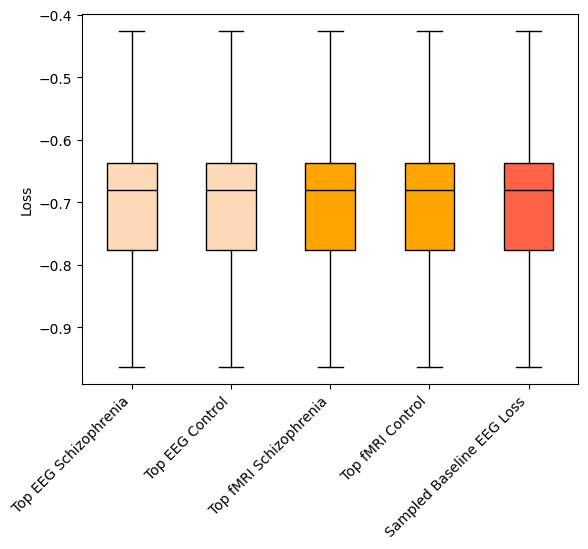

In [289]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and standard deviation
mean_loss = np.mean(losses)
std_loss = np.std(losses)

# Print mean and standard deviation (optional)
print(f"Mean Loss: {mean_loss}")
print(f"Standard Deviation of Loss: {std_loss}")

import matplotlib.pyplot as plt
import numpy as np

loss_dists = [losses, losses, losses, losses, losses]
labels = ['Top EEG Schizophrenia', 'Top EEG Control', 'Top fMRI Schizophrenia', 'Top fMRI Control', 'Sampled Baseline EEG Loss']
colors = ['peachpuff', 'peachpuff', 'orange', 'orange', 'tomato']

fig, ax = plt.subplots()
ax.set_ylabel('Loss')

medianprops = dict(color='black', linewidth=1)
bplot = ax.boxplot(loss_dists,
                   patch_artist=True, medianprops=medianprops, labels=labels) 
# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(rotation=45, ha='right')
plt.show()

In [184]:
find_eeg_loss([1, 18, 169, 50, 20, 20, 0.9947340222111644, 0.13863990804764062, 0.4778618517797724, 1.0, 0.49200461159728687])

1 18 169 50 20 20 0.9947340222111644 0.13863990804764062 0.4778618517797724 1.0 0.49200461159728687
078f490e765ff024560aa4777a1307d8
Creating RawArray with float64 data, n_channels=62, n_times=2000
    Range : 0 ... 1999 =      0.000 ...     1.999 secs
Ready.
Effective window size : 2.000 (s)


-0.676112585970852

In [292]:
# Same - baseline loss but for FC matrices. 
from nilearn import image, connectome, plotting
from nilearn.maskers import NiftiLabelsMasker
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [316]:
# Only run if calculating the averaged FC matrix from already computed npy files
bold_losses = []

npy_dir = 'fc_matrices'

def generate_random_tuples(num_tuples, range_min, range_max):
    random_tuples = []
    for _ in range(num_tuples):
        while True:
            # Generate two distinct random integers
            value1 = random.randint(range_min, range_max)
            value2 = random.randint(range_min, range_max)
            if value1 != value2:
                tuple_element = (value1, value2)
                random_tuples.append(tuple_element)
                break
    return random_tuples

random_pairs = generate_random_tuples(30, 4, len(os.listdir(npy_dir))-1)

for (p1, p2) in random_pairs:
    c_matrix1 = np.load(os.path.join(npy_dir, os.listdir(npy_dir)[p1]))
    c_matrix2 = np.load(os.path.join(npy_dir, os.listdir(npy_dir)[p2]))

    pearson_corr = np.corrcoef(np.ravel(c_matrix1), np.ravel(c_matrix2))[0, 1]

    loss = -pearson_corr
    bold_losses.append(loss)


In [319]:
np.save('baseline_losses_bold.npy', np.array(bold_losses, dtype=object), allow_pickle=True)

Mean Loss: -0.3738061887027575
Standard Deviation of Loss: 0.11617223203530305


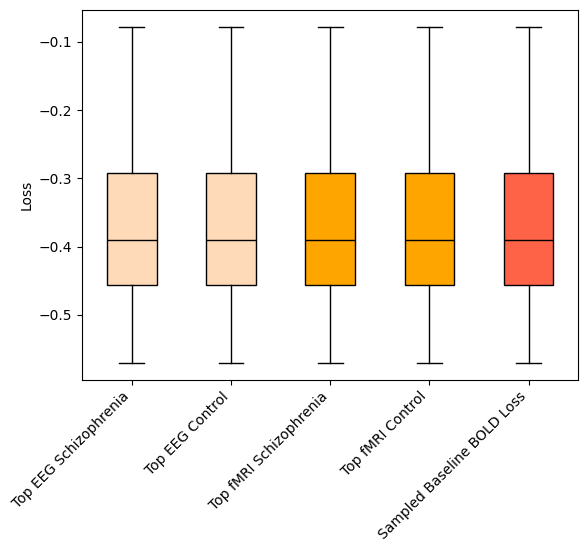

In [318]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and standard deviation
mean_loss = np.mean(bold_losses)
std_loss = np.std(bold_losses)

# Print mean and standard deviation (optional)
print(f"Mean Loss: {mean_loss}")
print(f"Standard Deviation of Loss: {std_loss}")

import matplotlib.pyplot as plt
import numpy as np

loss_dists = [bold_losses, bold_losses, bold_losses, bold_losses, bold_losses]
labels = ['Top EEG Schizophrenia', 'Top EEG Control', 'Top fMRI Schizophrenia', 'Top fMRI Control', 'Sampled Baseline BOLD Loss']
colors = ['peachpuff', 'peachpuff', 'orange', 'orange', 'tomato']

fig, ax = plt.subplots()
ax.set_ylabel('Loss')

medianprops = dict(color='black', linewidth=1)
bplot = ax.boxplot(loss_dists,
                   patch_artist=True, medianprops=medianprops, labels=labels) 
# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(rotation=45, ha='right')
plt.show()